In [3]:
#test
import psycopg2
import pandas as pd

In [4]:
connection = psycopg2.connect(user = "sql",
                                  password = "sqL2020",
                                  host = "host1",  # hostname where the postgre database runs on
                                  port = "5433",
                                  database = "wwi")


In [111]:
sql_string='''
            select 
            --first_amt.customer_id,
            first_amt.ym as year_month,
            --last_amt.ym,
            first_amt.first_order_amt as first_order_amount,
            last_amt.last_order_amt as last_order_amount,
            round(avg_table.avg_amt,2) Month_Average_Order_Amount
            from 
                    (
                        select 
                        o.customer_id,
                        to_char(o.order_date, 'YYYY-MM') ym,
                        sum(ol.quantity * ol.unit_price) first_order_amt
                        from 
                            sales.orders o,
                            sales.order_lines ol, 
                        (	select 
                            o.customer_id,
                        --	o.order_id,
                            to_char(o.order_date, 'YYYY-MM') order_year_month,
                            min(o.order_date ) first_order_date
                            from 
                            sales.orders o
                            --where
                            --o.customer_id = 1
                            group by o.customer_id,to_char(o.order_date, 'YYYY-MM')
                            order by o.customer_id ) 
                            first_order_table
                            where 
                            o.order_id = ol.order_id
                            and
                            o.order_date = first_order_table.first_order_date
                            and
                            o.customer_id = first_order_table.customer_id
                            --and
                            --o.customer_id  = 1
                            group by 
                            o.customer_id,
                            to_char(o.order_date, 'YYYY-MM')
                    )  
                        first_amt,
                    /*********************************/
                    (
                        select 
                            o.customer_id,
                            to_char(o.order_date, 'YYYY-MM') ym,
                            sum(ol.quantity * ol.unit_price) last_order_amt
                        from 
                            sales.orders o,
                            sales.order_lines ol, 
                            (select 
                            o.customer_id,
                        --	o.order_id,
                            to_char(o.order_date, 'YYYY-MM') order_year_month,
                            max(o.order_date ) last_order_date
                            from 
                            sales.orders o
                            group by o.customer_id,to_char(o.order_date, 'YYYY-MM')
                            order by o.customer_id ) 
                            last_order_table
                            where 
                            o.order_id = ol.order_id
                            and
                            o.order_date = last_order_table.last_order_date
                            and
                            o.customer_id = last_order_table.customer_id
                            group by 
                            o.customer_id,
                            to_char(o.order_date, 'YYYY-MM')
                    ) 
                        last_amt,
                    ( select distinct
                        o.customer_id,
                        to_char(o.order_date, 'YYYY-MM') ym,
                        avg(ol.quantity * ol.unit_price) over (partition by o.customer_id, to_char(o.order_date, 'YYYY-MM') order by o.customer_id,to_char(o.order_date, 'YYYY-MM')) avg_amt
                        from 
                            sales.orders o,
                            sales.order_lines ol 
                        where 
                        o.order_id = ol.order_id
                    ) 
                        avg_table
                    where 
                        first_amt.customer_id=last_amt.customer_id
                        and 
                        first_amt.customer_id = avg_table.customer_id
                        and 
                        first_amt.ym = avg_table.ym
                        and 
                        first_amt.ym = last_amt.ym
                        and first_amt.customer_id in (1055)
                      
          '''
df = pd.read_sql_query(sql_string, connection)
df

,year_month,first_order_amount,last_order_amount,month_average_order_amount
0,2015-12,243.0,1128.4,428.67
1,2016-01,538.0,296.0,1296.73
2,2016-02,1866.0,4656.5,450.75
3,2016-03,204.5,865.0,178.25
4,2016-04,17061.0,17061.0,1421.75
5,2016-05,2836.2,8479.4,862.15


In [130]:
import matplotlib.pyplot as plt

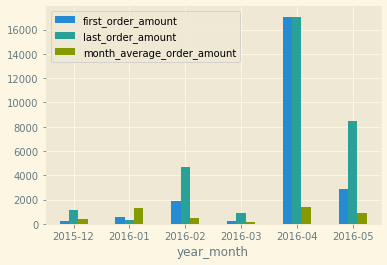

In [131]:
indexx = df['year_month']
dfx = pd.DataFrame({'first': df['first_order_amount'],'last': df['last_order_amount'], 
                    'avg':df['month_average_order_amount']}, index=indexx)

ax = df.plot.bar(x='year_month', rot=0)